# Classification on 3D Point Cloud Data 

Requirements:

Installing trimesh library

In [222]:
!pip install trimesh

In [203]:
import os  #provides various functions for interacting with operating systems

import glob #returns list of files with their full path

import tensorflow as tf #foundation library that can be used to create Deep Learning models

from tensorflow import keras #helps to do efficient numerical computations of Tensorflow

from tensorflow.keras import layers #for adding different layers including convolutional,pooling,dense layers in our model 

from matplotlib import pyplot as plt #library for data visualization and graphical plotting for 2d plots of arrays

import trimesh #python library for loading and using triangular meshes so point cloud data can be viewed as polygon figures

import numpy as np # provides support for large multidimensional array objects and various tools to work with them

tf.random.set_seed(1234) #for having same results, can be changed in future

# DataSet :
Here the dataset used(at present which is closest to dataset that will be produced by LIDAR i.e. 3d point cloud data) is ModelNet10 model dataset which is subset of ModelNet40 dataset.This is subset dataset of ModelNet40 contains near about 4,899 pre-aligned shapes from 10 categories(example sofa,chair,night_stand...).There are 3,991 (80%) shapes for training and 908 (20%) shapes for testing.Each shape is stored in  .off format(object file format which is a geometry definition file format containing description of the composing polygons of a geometric object. It can store 2d or 3d objects).

This dataset is provided by princeton university.

For further information regarding the dataset kindly refer to https://modelnet.cs.princeton.edu/

In case of issue in downloading the dataset I'll provide the dataset in seperate folder also.

In [178]:
#the below piece of code will download the file from given URL if it not already in the cache.
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)

#method to combine one or more path names into a single path.
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

# Visualization

Using trimesh library to read and visualize the .off(object file format) mesh files. It's a library for importing, exporting and doing simple operations on triangular meshes. 

For further information regarding trimesh library kindly refer to:https://trimsh.org/trimesh.html

In [226]:
triangular_mesh_created_using_trimesh = trimesh.load(os.path.join(DATA_DIR, "night_stand/train/night_stand_0010.off"))
triangular_mesh_created_using_trimesh.show()





Now there is need of conversion of the above mesh file into point cloud.
For this first we sample the points on mesh surface and performing the uniform sampling (random). We sample at 2048 locations and use matplotlib to show the results.




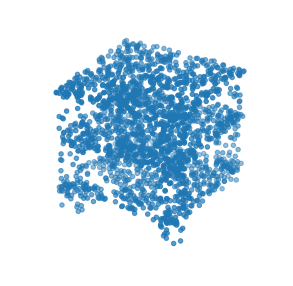

In [204]:
#axes3d is used since it takes a different kind of axis in order to actually graph something in three dimensions.
from mpl_toolkits.mplot3d import Axes3D 

#sampling the 2048 points on the mesh surface
points = triangular_mesh_created_using_trimesh.sample(2048)

#visualising the above trimesh in matplotlib by choosing the size and adding the subplots to it
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()

#final visualization in matplotlib
plt.show()

# Getting the dataset into desired format

We must first parse through the ModelNet data folders in order to construct a tf.data.Dataset(). Each mesh is imported into a point cloud and sampled, then added to a standard Python list and converted to a numpy array. The current enumerate index value is likewise saved as the object label, and we utilise a dictionary to retrieve it later.

In [205]:
#here each mesh is getting loaded (using trimesh.load()) and sampled into
#point cloud and is returned as an numpy array.
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        #Save the name of the folder along with the ID so we can get it later.
        
        class_map[i] = folder.split("/")[-1]
        
        # gathering all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

Now parsing the dataset by calling the above function and processing each of the classes.

In [206]:
NUM_POINTS = 2048

NUM_CLASSES = 10

BATCH_SIZE = 32 #means Batch_size amount of objects will be loaded at each batch when we'll be training our neural network.


train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: bathtub
processing class: bed
processing class: chair
processing class: night_stand
processing class: sofa
processing class: table
processing class: toilet


In [212]:
train_points.shape
#here this tuple represents (number of training objects, number of data point, xyz 3d coordinates)

(3126, 2048, 3)

# Augmentation for Dataset

Avoiding overfitting in the data space

In [213]:
#creating augmentation function to jitter and shuffle the train dataset

def augment(points, label):
    
    # jittering the points and adding the random noise of(0.05) to their position in xyz space
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
   
    # shuffle points preventing overfitting (possible that sample is in particular sequence and we don't want that bias in our solution)
    points = tf.random.shuffle(points)
    
    return points, label

#converting the data types to tf data type
train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

# Functions to build the Model

In [227]:
#defining convolutional layer , using 1d Convolutional layer(filter size will be of k*1) with padding as valid so the output will approximately 
#be of n/s size (where n:number of units in previous layer and s:stride value)
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    #each convolutional layer is followed by batch normalization layer(normalize the output from activation function and make sure weights in the process remains on same scale)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x) #Relu(rectified linear Unit is used as activation function it will output the input directly if it is positive, otherwise, it will output zero)

PointNet is made up of two main parts. The transformer network and the major MLP network (T-net). T-Net learns affine transformation matrix by it's own mini network.
We have used T-Net layer twice 
First time we have transformed the (number of data points,3) into canonical representation.Second is an affine transformation for alignment in feature space(n,3).However transformation matrix in the feature space has
much higher dimension than the spatial transform matrix,
which greatly increases the difficulty of optimization so we are adding a regularization term to our softmax training
loss.
As per the paper(https://arxiv.org/pdf/1612.00593.pdf) we constrain the transformation matrix to be close to an orthogonal matrix (i.e 
||(feature space)*(transposed feature space)- Identity Matrix ||=0) 

In [215]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

Below is the function for creating tnet layers which takes transformation and rotation of our point cloud into account. 

In [223]:
def tnet_for_affine_transformation(inputs, num_features):
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x) #global maxpooling layer to decrease the dimension for faster computation
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros", #Initializers define the way to set the initial random weights of Keras layers
        bias_initializer=bias,
        activity_regularizer=reg, #created above using orthogonal regualrizer
    )(x)
    
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

# Creating the whole Convolutional Neural Network

In [218]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet_for_affine_transformation(inputs, 3) #tnet layer
x = conv_bn(x, 32) #32 is filter size (changing dimension)
x = conv_bn(x, 32)
x = tnet_for_affine_transformation(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512) 
x = layers.GlobalMaxPooling1D()(x) #global maxpooling layer
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x) #drop prob is 0.3 to do regularization resulting in avoiding the overfitting 

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x) #Softmax converts a vector of values to a probability distribution.

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet") #name is name of the model 
model.summary() #represents the whole summary of above mentioned architecture

Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2048, 3)]    0                                            
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 2048, 32)     128         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2_34 (Batc (None, 2048, 32)     128         conv1d_22[0][0]                  
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 2048, 32)     0           batch_normalization_v2_34[0][0]  
___________________________________________________________________________________________

Here above we can see we have 742,899 are the trainable parameters where as 6,080 parameters are non trainable which are created by regularization

# Compiling and Training the Model

In [219]:
model.compile(
    loss="sparse_categorical_crossentropy", #cost function used which will be getting optimized at each iteration
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

#epochs =45 means 45 iterations of forward and backward propogation
#validation is passed to check how well model will work on testing data after each epoch

#note model is training on testing data (validation_data) it is just using it for prediction
model.fit(train_dataset, epochs=45, validation_data=test_dataset)

Epoch 1/45
98/98 [==============================] - 651s 7s/step - loss: 3.4033 - sparse_categorical_accuracy: 0.3401 - val_loss: 172982954071768000.0000 - val_sparse_categorical_accuracy: 0.4104
Epoch 2/45
98/98 [==============================] - 1097s 11s/step - loss: 2.6506 - sparse_categorical_accuracy: 0.5218 - val_loss: 459934123740072000.0000 - val_sparse_categorical_accuracy: 0.5377
Epoch 3/45
98/98 [==============================] - 611s 6s/step - loss: 2.5234 - sparse_categorical_accuracy: 0.5592 - val_loss: 89478878531704304.0000 - val_sparse_categorical_accuracy: 0.5519
Epoch 4/45
98/98 [==============================] - 607s 6s/step - loss: 2.2728 - sparse_categorical_accuracy: 0.6420 - val_loss: 66764436465529768.0000 - val_sparse_categorical_accuracy: 0.5597
Epoch 5/45
98/98 [==============================] - 612s 6s/step - loss: 2.2126 - sparse_categorical_accuracy: 0.6593 - val_loss: 1003380687481994624.0000 - val_sparse_categorical_accuracy: 0.6745
Epoch 6/45
98/98 [=

Epoch 43/45
98/98 [==============================] - 617s 6s/step - loss: 1.2953 - sparse_categorical_accuracy: 0.9207 - val_loss: 169419100509340.2500 - val_sparse_categorical_accuracy: 0.8601
Epoch 44/45
98/98 [==============================] - 616s 6s/step - loss: 1.2841 - sparse_categorical_accuracy: 0.9341 - val_loss: 897581404236388.1250 - val_sparse_categorical_accuracy: 0.8789
Epoch 45/45
98/98 [==============================] - 616s 6s/step - loss: 1.2727 - sparse_categorical_accuracy: 0.9322 - val_loss: 8231380403799571.0000 - val_sparse_categorical_accuracy: 0.8711


# Result
above we can see that in only 45 epochs our loss has been reduced from 3.4033 to  1.2727 and training accuracy has been increased from 34% to 93% . While we can see that we have reached testing accuracy of max 90.88% at epoch 35.

Note: This accuracy can definitely be increase in future by running this model for higher number of epochs and storing only that model which has increasing testing accuracy only.

# Visulasizing one of the predictions

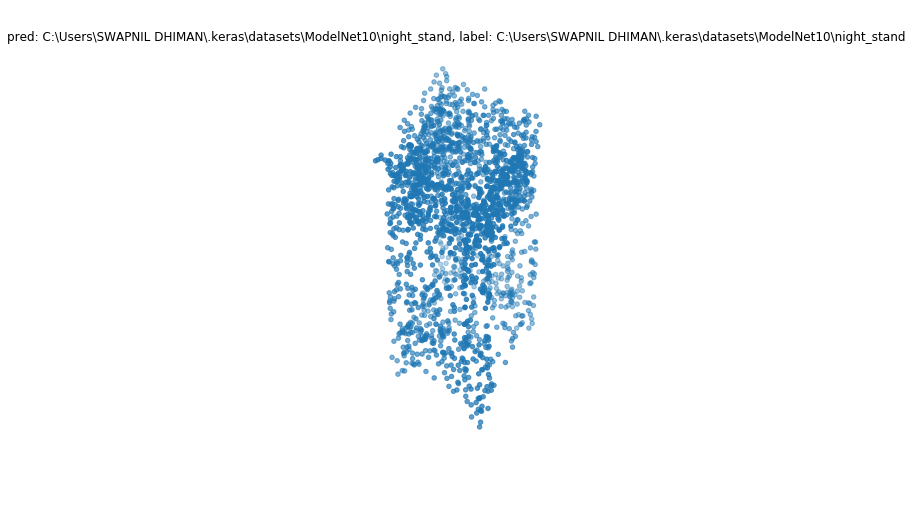

In [224]:
data = test_dataset.take(2)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1) #getting the index of the class which will be maximum

#points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(2, 4, 1, projection="3d")
ax.scatter(points[0, :, 0], points[0, :, 1], points[0, :, 2])
ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[0].numpy()], CLASS_MAP[labels.numpy()[0]]
    )
)
ax.set_axis_off()
plt.show()


Above we can see that predicted class is night_stand and actual class was also night_stand

For more knowledge kindly refer to this paper(tried implementing classification networking part) : https://arxiv.org/pdf/1612.00593.pdf